In [1]:
import time
from typing import List, Dict, Tuple
import numpy as np
from pydrake.all import (
    AddMultibodyPlantSceneGraph,
    BsplineTrajectory,
    DiagramBuilder,
    KinematicTrajectoryOptimization,
    MeshcatVisualizer,
    MeshcatVisualizerParams,
    DiagramBuilder,
    MinimumDistanceLowerBoundConstraint,
    Parser,
    PositionConstraint,
    Rgba,
    RigidTransform,
    Role,
    Solve,
    Sphere,
    StartMeshcat,
    Simulator
)

from pydrake.geometry import Meshcat
from manipulation import running_as_notebook
from manipulation.meshcat_utils import PublishPositionTrajectory
from manipulation.scenarios import AddIiwa, AddPlanarIiwa, AddShape, AddWsg
from manipulation.utils import ConfigureParser

In [2]:
from pydrake.all import Meshcat
meshcat = Meshcat(7006)

INFO:drake:Meshcat listening for connections at http://localhost:7006


In [3]:
def create_shelf_files(template_file: str, book_labels: List[str]):
    
    shelf_files = {}
    
    with open(template_file+".sdf", 'r') as f:

        library_file = f.read()

        for book_label in book_labels:
            book_file = library_file.replace('<model name="shelf_NUMBER">',
                                            f'<model name="shelf_{book_label}">')
            new_file_name = template_file + "_" + book_label + ".sdf"
            with open(new_file_name,'w') as ftmp:
                ftmp.write(book_file)

            shelf_files[book_label] = new_file_name
    return shelf_files

def setup_builder(mcat: Meshcat, time_step: float = 0.001):

    mcat.Delete()
    mcat.DeleteAddedControls()
    
    builder = DiagramBuilder()
    plant, scene_graph = AddMultibodyPlantSceneGraph(builder, time_step=time_step)
    parser = Parser(plant)
    ConfigureParser(parser)
    
    return builder, plant, scene_graph, parser

In [4]:
BOOK_LABELS = ["A","B","C","D","E","F"]
TEMPLATE_SHELF_FILE = "library_shelf"
N_COLUMNS = 2
N_ROWS = len(BOOK_LABELS)//N_COLUMNS
ROW_DIST_SHELF = np.array([1.4,0.0,0.0])
COLUMN_DIST_SHELF = np.array([0.0,1.4,0.0])
SHELF_OFFSET = np.array([0.8,1.8,0.0])

shelf_files = create_shelf_files(TEMPLATE_SHELF_FILE, BOOK_LABELS)
builder, plant, scene_graph, parser = setup_builder(meshcat)

In [5]:
from bs4 import BeautifulSoup

def convert_xml_to_array(keyword, object) -> np.ndarray:
    return np.array(str(object).strip(keyword).rstrip("</").strip(" ").split(" ")).astype('float')

def find_max_min_extension_of_object(sdf_file) -> Tuple[np.ndarray, np.ndarray]:

    with open(sdf_file, 'r') as f:
        data = f.read()
 
    Bs_data = BeautifulSoup(data, "xml")
    
    max_extension = np.array([-1e6,-1e6,-1e6])
    min_extension = np.array([1e6,1e6,1e6])
    
    for visual in Bs_data.find_all("visual"):
        pose_arr = convert_xml_to_array("<pose>",visual.pose)
        size_arr = convert_xml_to_array("<size>",visual.size)
        extension = (pose_arr[:3] + size_arr/2)
        max_extension = np.max(np.stack([extension,max_extension]),axis=0)
        min_extension = np.min(np.stack([extension,min_extension]),axis=0)
    
    return min_extension, max_extension

In [6]:
def add_shelves(shelf_files: Dict[str,str], 
                row_dist: np.ndarray, 
                col_dist: np.ndarray,
                parser: Parser) -> None:
    
    shelf_label_pos = {}

    for idx, (shelf_label,shelf_file) in enumerate(shelf_files.items()):

        min_extension, _ = find_max_min_extension_of_object(shelf_file)

        row = idx//N_COLUMNS
        column = idx % N_COLUMNS
        shelf_label_pos[shelf_label] = (row,column)

        p = -min_extension + row * row_dist + column * col_dist + SHELF_OFFSET

        bin = parser.AddModels(shelf_file)[0]

        plant.WeldFrames(
            plant.world_frame(),
            plant.GetFrameByName("shelves_body", bin),
            RigidTransform(list(p)))
    return shelf_label_pos


In [7]:
def add_table(table_file: str, 
              parser: Parser):
     
    min_extension, _ = find_max_min_extension_of_object(table_file)

    bin = parser.AddModels(table_file)[0]
     
    p = np.array([1.0,0.25,.50])
    plant.WeldFrames(
        plant.world_frame(),
        plant.GetFrameByName("table", bin),
        RigidTransform(list(p)))

In [8]:
shelf_label_pos = add_shelves(shelf_files,ROW_DIST_SHELF,COLUMN_DIST_SHELF,parser)

In [9]:
add_table("library_table.sdf",parser)

In [10]:
plant.Finalize()
visualizer = MeshcatVisualizer.AddToBuilder(builder, scene_graph, meshcat)
diagram = builder.Build()
diagram.set_name("plant and scene_graph")
context = diagram.CreateDefaultContext()
diagram.ForcedPublish(context)

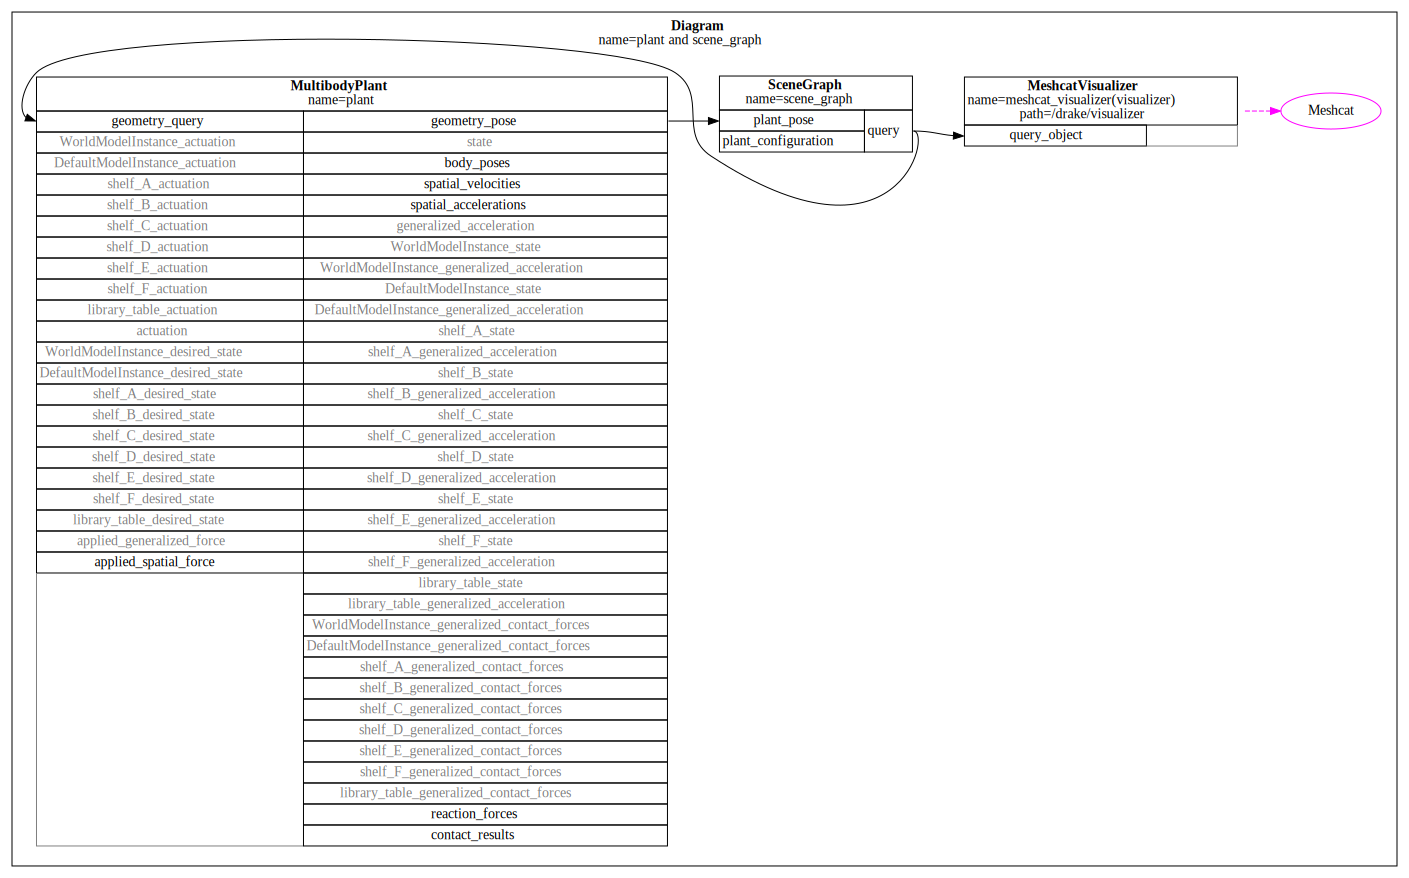

In [11]:
from utils import visualize_diagram
visualize_diagram(diagram)